##### time_step_embedding exponentially decreasing frequencies used to represent sigma_t
- achieved by linearly spaced integers in logspace multiplied by negative number then exponentiated
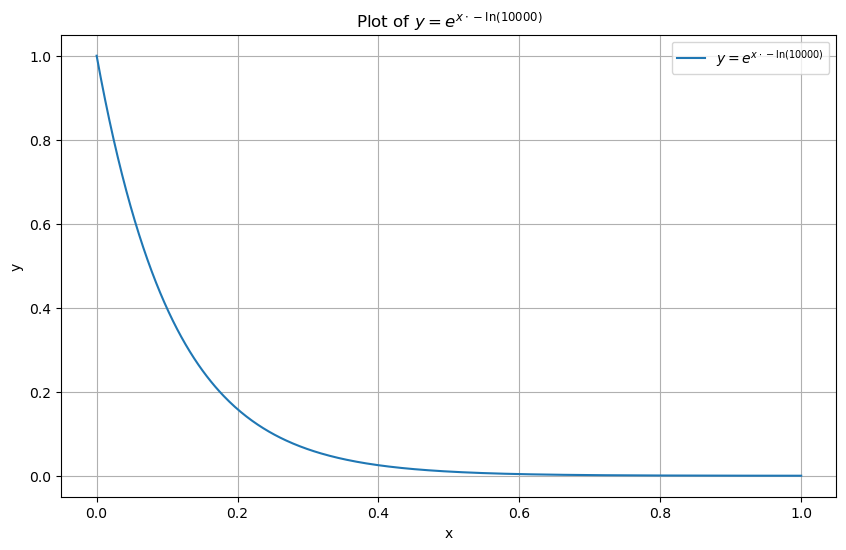

#### 1d position embedding exponentially decreasing frequencies
- achieved by  linearly spaced integers from 0 to 1 exponentiated to a number less than 0
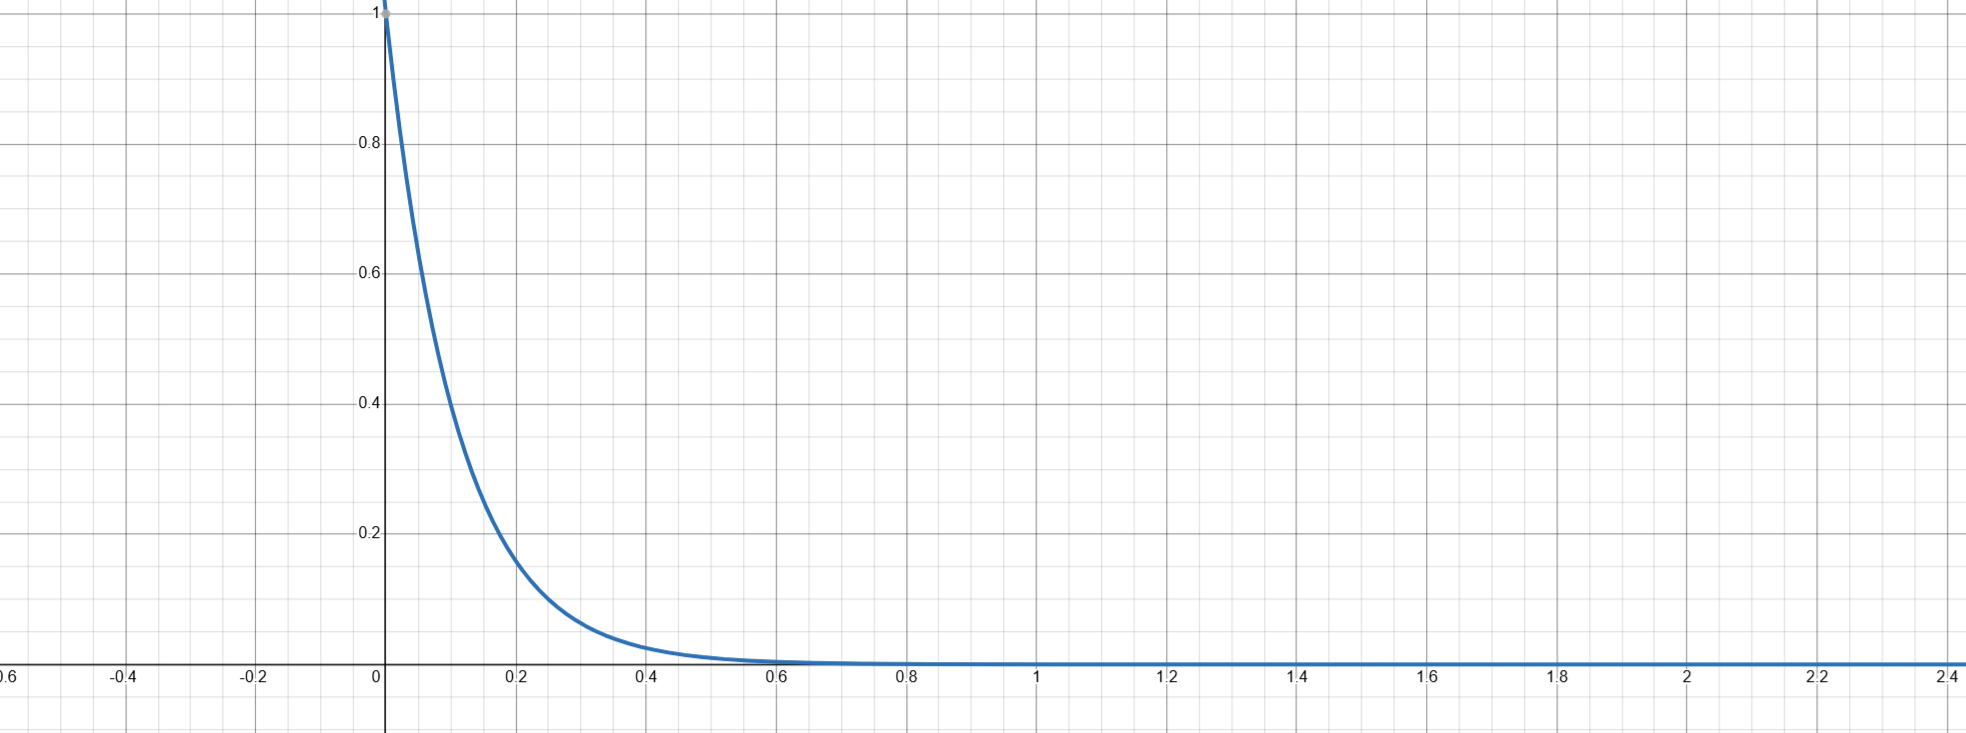

- unsqueeze and einsum for injecting sigma_t or position index into frequencies are the same thing
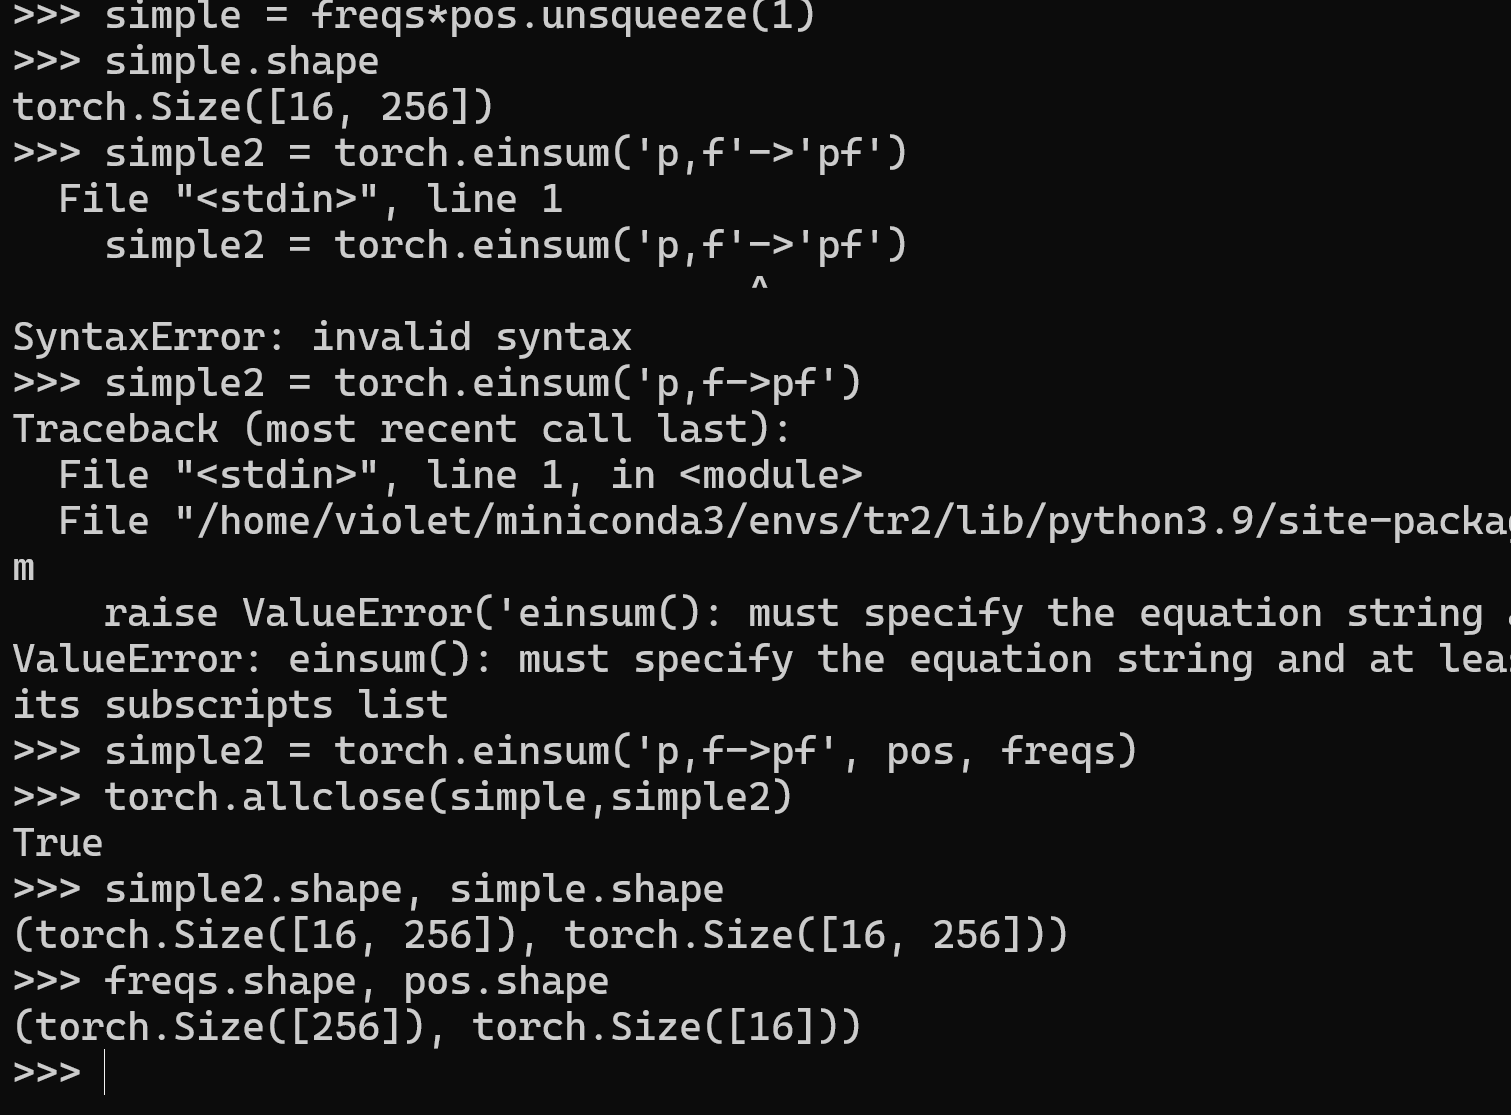

In [2]:
import torch
import torch.nn as nn
import math
max_period = 100
dim = 10
half = dim // 2
freqs = torch.exp (
    # divide by half at the end so that we dont get absurdly small numebrs
    -math.log(max_period) * (torch.arange(start=0, end=half, dtype=torch.float32, device='cuda'))/half
)

freqs.shape

# 4
# -2 * (0 , 1, 2, 3)
# (0, -2, -4, -6) / 4
# (0, -0.5, -1, -1.5)

torch.Size([5])

In [22]:
t = torch.tensor([5])

t[:, None].shape, t.shape, t.unsqueeze(1).shape, torch.allclose(t[:, None], t.unsqueeze(1)), freqs.shape

(torch.Size([1, 1]),
 torch.Size([1]),
 torch.Size([1, 1]),
 True,
 torch.Size([5]))

In [23]:
#[1,1] * [5]
scaled_sigma_t = t.unsqueeze(1).to('cuda') * freqs
without_extra_dim = t.to('cuda') * freqs
scaled_sigma_t.shape, without_extra_dim.shape

(torch.Size([1, 5]), torch.Size([5]))

In [24]:
scaled_sigma_t, scaled_sigma_t.shape, freqs, t

(tensor([[5.0000, 1.9905, 0.7924, 0.3155, 0.1256]], device='cuda:0'),
 torch.Size([1, 5]),
 tensor([1.0000, 0.3981, 0.1585, 0.0631, 0.0251], device='cuda:0'),
 tensor([5]))

In [25]:
# now my arguments to sinusoids are 
args = scaled_sigma_t

embedding = torch.cat((torch.cos(args), torch.sin(args)), dim=-1)
assert embedding.shape[-1] == 10

args.shape, embedding.shape

(torch.Size([1, 5]), torch.Size([1, 10]))

In [26]:
torch.zeros_like(embedding[:, :1])

tensor([[0.]], device='cuda:0')

In [27]:
# append bias term (0 freq component)
torch.allclose(torch.zeros_like(embedding[:, 0]), torch.zeros_like(embedding[:, :1]))

True

In [28]:
scaled_sigma_t = t.unsqueeze(1).to('cuda') * freqs.to('cuda')
bullshit = t[:, None].float().to('cuda') * freqs[None].to('cuda')
torch.allclose(scaled_sigma_t, bullshit)

True

In [30]:
class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.
    
    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer,
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    def forward(self, x):
        #print (self.dtype)
        return x

In [31]:
a = TimestepEmbedder(1, nn.GELU(), 512)
a(1)

1

In [32]:
type(a)

__main__.TimestepEmbedder

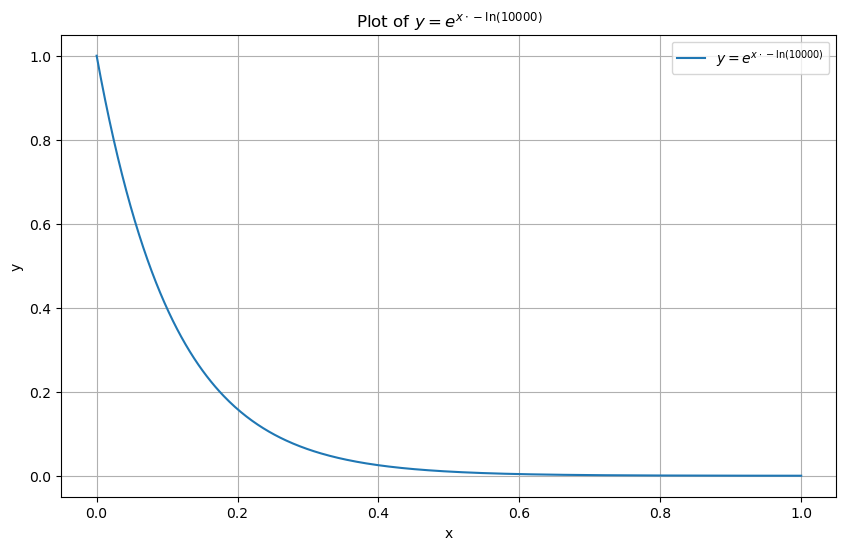

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 500 linearly spaced numbers between 0 and 1
x = np.linspace(0, 1, 500)

# Multiply by -log(10000) to get a descending list with increasing magnitude
log_value = -np.log(10000)
transformed_list = x * log_value

# Calculate y = e^transformed_list
y = np.exp(transformed_list)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r'$y = e^{x \cdot -\ln(10000)}$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of $y = e^{x \cdot -\ln(10000)}$')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def embed_timestep (sigma_t, n_t_embd, max_period = 10000):
        # half the time embedding dimensions will be cosine rest of half will be sine
        # if n_t_embd is odd, then we append 0 frequency component to maintain consistency
        half = n_t_embd // 2

        log_freqs = -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=sigma_t.device)
        # now we have log_freqs in descending order, they start from 0 and grow negative as we move right
        # later we exponentiate log_freqs to get frequencies, and exp(verylarge negative number) is very small
        # we dont want frequency components that are really close to 0 and almost indistinguishable from each other at the tail end
        # thats why we scale down these negative numbers by "half" so that we have smaller negative numbers
        log_freqs = log_freqs / half
        # exponentiate to get freqs
        freqs = torch.exp (log_freqs) 
        # note that we resort to exponential scale /decay to ensure wide range of dfs
        # df would be constant in linear scale

        sigma_t = sigma_t.unsqueeze(1) #(1, 1)
        args = sigma_t * freqs # (1,1) * (half)
        # args is now (1, half)
        # embedding vector thats n_t_embd long if n_t_embd is even
        # otherwise its n_t_embd - 1
        embedding = torch.cat((torch.cos(args), torch.sin(args)), dim=-1)

        if n_t_embd % 2 != 0:
            # rectify the dimensionality of the embedding if n_t_embd was odd
            # n_t_embd - 1 -> n_t_embd by appending 0 frequency component
            embedding = torch.cat((embedding, torch.zeros_like(embedding[:, 0])), dim=-1)
        return embedding #(1, n_t_embd)

a = embed_timestep (torch.tensor([80]), 512)

In [8]:
a.shape

torch.Size([1, 512])